## Sample Analysis for Tracker Observables

Begin by importing the allmighty `numpy` and `pyplot`

In [61]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as img
import random 

### Michael's Descrption of the Files

Now we will import the `numpy` arrays containing the simulation data. The `*_details` array contains the weight of each event and the energy deposited in each scintillator and the calorimeter for said event. The `*_images` array contains the 25x25 tracker images for each event. For each event, there are four tracker images. The way to read the data is that the `nth` event has `weight` in `*_details[n,0]`, scintillator history `*_details[n,1:9]`, calorimeter energy `*_details[n,10]`, and `*_images[:,:,n]`, `*_images[:,:,n+1]`, `*_images[:,:,n+2]`, `*_images[:,:,n+3]` are the four tracker iamges corresponding with the order in which the trackers are reached from the LHC. The `weight` contained in `*_details[n,0]` only takes into account the relative weight of neutrino interactions in the lead to the neutrino interactions in the tungsten.

**Note by Felix:** I assume that it should be `*_images[:,:,4n]`, `*_images[:,:,4n+1]`, ... . 

### Felix format

The above description is fine, but slightly confusing and perhaps a bit too space consuming. Below, I suggest a new format using a dictionary. The main space reduction comes from saving the coordinates of pixels that were hit (instead of storing lots of zeros for pixels that are not hit). 

In [51]:
def compress_data():

    # initialze data
    data = []

    # loop over files: 
    for nfile in range(94):

        # load data
        details = np.load('NumpyArrays/neutrino_details.npy')
        images = np.load('NumpyArrays/neutrino_images_'+str(nfile)+'.npy')

        # loop over 250 events in file, store data in new format
        for n in range(250):
            #load event weight, scintillator and calo info
            weight, scintillator, calo = details[n,0], details[n,1:9], details[n,10]
            #load 4 tracker layers
            layer1, layer2, layer3, layer4 = images[:,:,4*n], images[:,:,4*n+1], images[:,:,4*n+2], images[:,:,4*n+3]
            # store scintillator as 0/1 
            scintillator = [ int (value > 1e-4) for value in scintillator]
            # store coordinates and track multiplicity for pixel that have at least one track
            hits1, hits2, hits3, hits4 = [], [], [], []
            for ix in range(25):
                for iy in range(25):
                    if layer1[ix,iy]>0.1: hits1.append([ix-12, iy-12, int(layer1[ix,iy]/0.1)])
                    if layer2[ix,iy]>0.1: hits2.append([ix-12, iy-12, int(layer2[ix,iy]/0.1)])
                    if layer3[ix,iy]>0.1: hits3.append([ix-12, iy-12, int(layer3[ix,iy]/0.1)])
                    if layer4[ix,iy]>0.1: hits4.append([ix-12, iy-12, int(layer4[ix,iy]/0.1)])

            eventdata = {}
            eventdata['weight'] = weight
            eventdata['scintillator'] = np.array(scintillator)
            eventdata['calo'] = round(calo,3)
            eventdata['hits1'] = np.array(hits1)
            eventdata['hits2'] = np.array(hits2)
            eventdata['hits3'] = np.array(hits3)
            eventdata['hits4'] = np.array(hits4)
            data.append(eventdata)

    np.save('NumpyArrays/neutrino_data.npy', data)
    
compress_data()

Now we can load the data

In [45]:
data = np.load('NumpyArrays/neutrino_data.npy')

And look at some event: 

In [50]:
print (data[77])

{'hits4': [[-7, -1, 1]], 'hits3': [[-7, -1, 1], [-5, 9, 1], [-5, 10, 1], [-5, 11, 1], [-4, 10, 1], [8, 3, 2]], 'hits2': [[-6, -2, 1], [-5, -1, 2]], 'weight': 1.0, 'scintillator': array([1, 1, 1, 1, 1, 1, 1, 1]), 'calo': 11.19, 'hits1': [[-4, -3, 1]]}


### Display event

Here is some quick event display function I wrote based on Michael's code

In [335]:
def display_event(ievent=0):
    
    #load event
    event = data[ievent]
    if event['scintillator'][0]> 0: return 0
    if event['scintillator'][1]==0: return 0 
    
    # initialize
    multiplier=2
    matplotlib.rcParams.update({'font.size': 15*multiplier})
    matplotlib.rcParams['axes.linewidth'] = multiplier
    fig = plt.figure(figsize=(16*multiplier,7*multiplier))
    
    # Setup some nice axes 
    x0, x1 = 0.01, 0.94
    width = (x1-x0)/4
    h_tr, h_pic, h_sc = 0.55, 0.35, 0.08
    ax0 = fig.add_axes([x0          , 0.02+h_tr      , (x1-x0)   , h_pic])    
    ax1 = fig.add_axes([x0 + 0*width, 0.02           , width     , h_tr ])
    ax2 = fig.add_axes([x0 + 1*width, 0.02           , width     , h_tr ])
    ax3 = fig.add_axes([x0 + 2*width, 0.02           , width     , h_tr ])
    ax4 = fig.add_axes([x0 + 3*width, 0.02           , 1.25*width, h_tr ])
    ax5 = fig.add_axes([x0          , 0.02+h_tr+h_pic, 0.8       , 0.05  ])
    ax6 = fig.add_axes([x0+0.8      , 0.02+h_tr+h_pic, x1-x0-0.8 , 0.05  ])
    
    #plot image of detector
    image = img.imread('Fig_Layout.jpg')
    ax0.imshow(image)
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.spines.clear()
    
    # Plot the tracker images
    bins = (np.linspace(-12.5, 12.5, 26),np.linspace(-12.5, 12.5, 26))
    for ax, layer in zip([ax1,ax2,ax3,ax4],['hits1','hits2','hits3','hits4']):
        image = np.array(event[layer])
        if len(image)==0: image = np.array([[0,0,0]])
        hist = ax.hist2d(image.T[0], image.T[1], weights=image.T[2], bins=bins, 
                  norm=matplotlib.colors.LogNorm(),vmin=1,vmax=100,cmap='cool')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(hist[3], ax=ax4)
    
    # Plot scintillators
    ax5.hist2d(np.linspace(0.5,7.5,8), np.zeros(8) , weights=event['scintillator'], bins=(np.linspace(0,8,9),[-1,1]), 
                  norm=matplotlib.colors.LogNorm(),vmin=0.1,vmax=1,cmap='rainbow')
    for x in np.linspace(0,7,8): 
        ax5.plot([x,x],[-1,1],lw=multiplier,c="k")
        ax5.text(x+0.06,-0.75,str(int(x+1)))
    ax5.set_xticks([])
    ax5.set_yticks([])
    
    # Plot calorimeter
    ax6.text(0.5,0.5,"E="+str(event['calo'])+" GeV",ha="center", va="center")
    ax6.fill([0,1,1,0], [0,0,1,1], c="lightgreen")
    ax6.set_xlim(0,1)
    ax6.set_ylim(0,1)
    ax6.set_xticks([])
    ax6.set_yticks([])

    # Return figure so user can manipulate or save the plots
    plt.savefig("EventDisplays/Event_"+str(ievent)+".pdf")
    plt.show()
    
    return 1


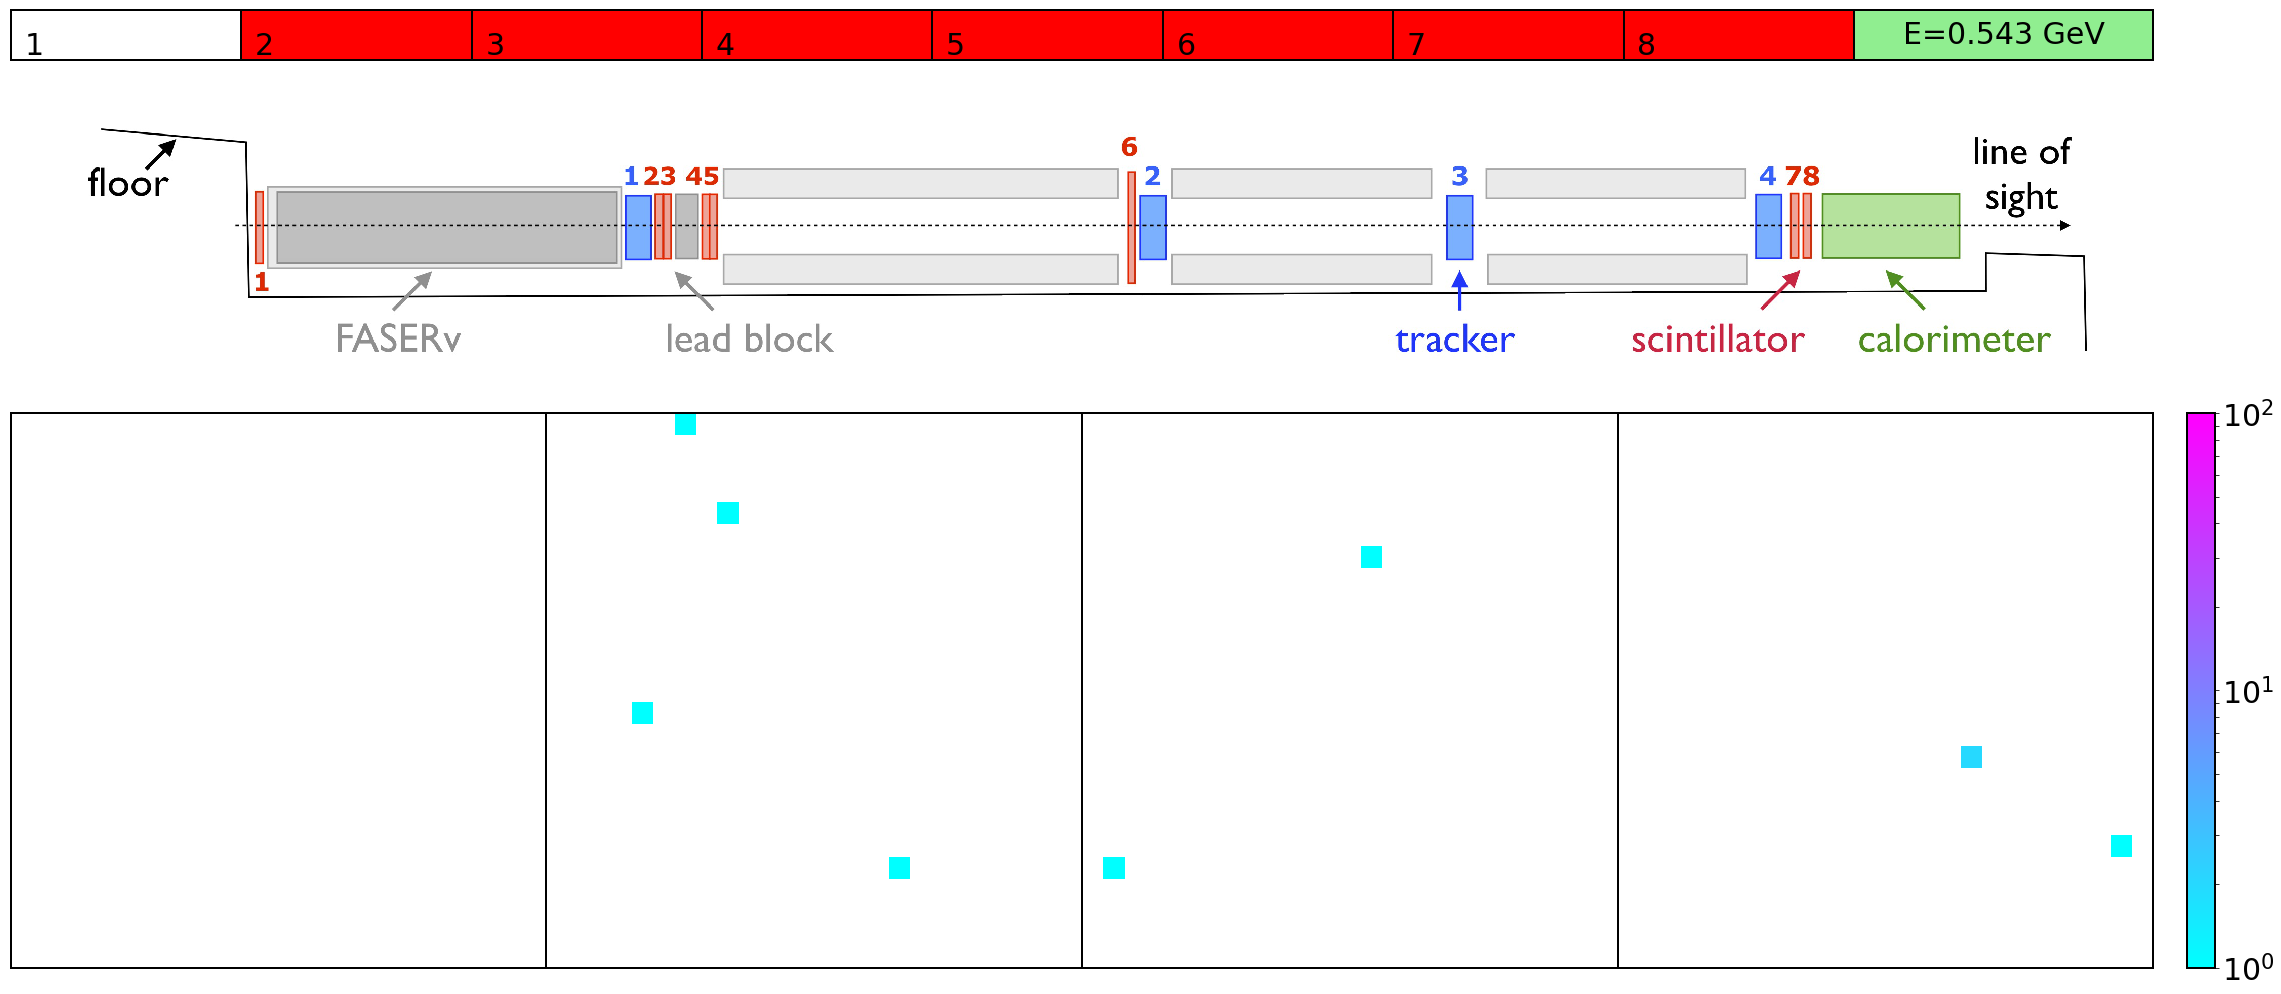

In [338]:
numevents = 0 
while numevents < 1:
    ievent = random.randrange(len(data))
    numevents+=display_event(ievent=ievent)